In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import emcee
from scipy.special import ndtri
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd

In [2]:
grbparam = pd.read_csv('GRBPARAM.csv', index_col=0)
# [grbname.replace('.txt','')]

In [3]:
grbname = 'GRB081221.txt'
arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
grbname_wtht_ext = grbname.replace('.txt','')
#Properties of GRB081221
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
nplot = 1000 #burn-in
H0=70 #km/s/Mpc Taken from Sir's Code
param_ranges_NULL = [(1e-20, 5000), (-3, 10), (-10, 3), (1e-20, 3), (1e-20, 4)]
param_range_lin = [(1e-20, 1e20), (1e-20, 5000), (-3, 10), (-10, 3), (1e-20, 3), (1e-20, 4)]
param_range_quad = [(1e-20, 1e15), (1e-20, 5000), (-3, 10), (-10, 3), (1e-20, 3), (1e-20, 4)]
data = [arr[:,0], arr[:,1], arr[:,2]]


M = len(data[0])


x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

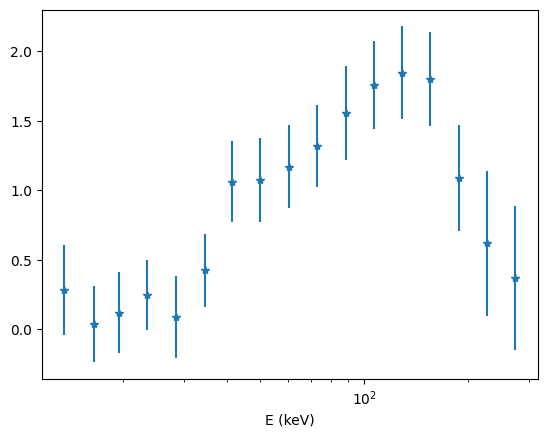

In [4]:
# plt.plot(arr[:,0], arr[:,1], '*')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2], fmt='*')
plt.xlabel('E (keV)')
plt.xscale('log')
plt.show()

In [5]:
def MODEL_delta_t_intrinsic(E, Eb, alpha1, alpha2, mu, zeta):
    
    E0b = (E - E0)/(Eb)
    return zeta * (E0b ** alpha1) * (1 + E0b ** ((alpha2 - alpha1)*mu))/2


def int_over_red_shift(z, n):
    '''
    Integrate over redshift
    
    Parameters
    ----------
    z : float
        Redshift
    n : float
        LIV Polynomial power        
    '''
    
    
    #    f = lambda x: ((1+x)**n)/h_gp(x)
    f = lambda x: ((1+x)**n)/np.sqrt(0.3*(1+x)**3 + 0.7)
    return quad(f, 0, z)[0]


K_z1 = int_over_red_shift(z_com,1)
K_z2 = int_over_red_shift(z_com,2)
	
def linear(E, z, logE_qg, Eb, alpha1, alpha2, mu, zeta):
    K_z= np.asarray(K_z1)
    return MODEL_delta_t_intrinsic(E, Eb, alpha1, alpha2, mu, zeta) + (-(10**14)/(H0*3.24))*((E - E0)*K_z/((10**logE_qg)*(1+z)))

def quadratic(E, z, logE_qg, Eb, alpha1, alpha2, mu, zeta):
    E_0=E0rest/(1+z)
    Eres=E/(1+z)
    K_z = np.asarray(K_z2)
    return MODEL_delta_t_intrinsic(E, Eb, alpha1, alpha2, mu, zeta) + (-1.5*(10**8)/(H0*3.24))*((Eres**2 - E_0**2)*K_z/(10**logE_qg)**2)

In [6]:
def loglklhood_null_HP(theta):
    # if E0 in args:
    # x, y, yerr = data
    Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = MODEL_delta_t_intrinsic(x, Eb, alpha1, alpha2, mu, zeta)
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    return -np.inf

def loglklhood_LIV_lin(theta1):
    
    logE_qg, Eb, alpha1, alpha2, mu, zeta = theta1
    
    if alpha1 >= alpha2:
        model = linear(x, z_com, logE_qg, Eb, alpha1, alpha2, mu, zeta)    
        return sum(stats.norm.logpdf(*rgs) for rgs in zip(y,model,yerr))
    return -np.inf

def loglklhood_LIV_quad(theta2):
    
    logE_qg, Eb, alpha1, alpha2, mu, zeta = theta2
    if alpha1 >= alpha2:
        model = linear(x, z_com, logE_qg, Eb, alpha1, alpha2, mu, zeta)    
        return sum(stats.norm.logpdf(*rgs) for rgs in zip(y,model,yerr))
    return -np.inf

In [19]:
def log_prior_null(theta):
    Eb, alpha1, alpha2, mu, zeta = theta
    
    if param_ranges_NULL[0][0] < Eb < param_ranges_NULL[0][1] and param_ranges_NULL[1][0] < alpha1 < param_ranges_NULL[1][1] and param_ranges_NULL[2][0] < alpha2 < param_ranges_NULL[2][1] and param_ranges_NULL[3][0] < mu < param_ranges_NULL[3][1] and param_ranges_NULL[4][0] < zeta < param_ranges_NULL[4][1]:
        return 0.0 # + prior_return
    return -np.inf


def log_prior_LIV_lin(theta1):
    logE_qg, Eb, alpha1, alpha2, mu, zeta = theta1
    
        
    if logE_qg < np.log10(param_range_lin[0][1]) and param_range_lin[1][0] < Eb < param_range_lin[1][1] and param_range_lin[2][0] < alpha1 < param_range_lin[2][1] and param_range_lin[3][0] < alpha2 < param_range_lin[3][1] and param_range_lin[4][0] < mu < param_range_lin[4][1] and param_range_lin[5][0] < zeta < param_range_lin[5][1]:
        return 0.0 #- logE_qg
    return -np.inf


def log_prior_LIV_quad(theta2):
    logE_qg, Eb, alpha1, alpha2, mu, zeta = theta2
        
    if logE_qg < np.log10(param_range_quad[0][1]) and param_range_quad[1][0] < Eb < param_range_quad[1][1] and param_range_quad[2][0] < alpha1 < param_range_quad[2][1] and param_range_quad[3][0] < alpha2 < param_range_quad[3][1] and param_range_quad[4][0] < mu < param_range_quad[4][1] and param_range_quad[5][0] < zeta < param_range_quad[5][1]:
        return 0.0 #-logE_qg
    return -np.inf

In [20]:
def logposterior_NULL(theta):
    
    lprior = log_prior_null(theta)
    

    return lprior + loglklhood_null_HP(theta)

def logposterior_LIV_lin(theta1):
    
    lprior = log_prior_LIV_lin(theta1)
    
    if not np.isfinite:
        return -np.inf
    
    return lprior + loglklhood_LIV_lin(theta1)

def logposterior_LIV_quad(theta2):
    
    lprior = log_prior_LIV_quad(theta2)
    
    if not np.isfinite:
        return -np.inf
    
    return lprior + loglklhood_LIV_quad(theta2)

In [21]:
Nens = 1000
Nburn = 500
Nsamples = 1000
ndim_NULL = 5
ndim_LIV = 6

In [22]:
param_ranges_NULL[0]

(1e-20, 5000)

In [29]:
inisamp_null = [np.exp(np.random.uniform(np.log(param_ranges_NULL[0][0]), np.log(param_ranges_NULL[0][1]), Nens))]
# inisamp_null = np.array(inisamp0_null.append([np.random.uniform(param_ranges_NULL[i][0], param_ranges_NULL[i][1], Nens) for i in range(1, ndim_NULL)])).T
for i in range(1, ndim_NULL):
    inisamp_null.append(np.random.uniform(param_ranges_NULL[i][0], param_ranges_NULL[i][1], Nens))
    
inisamp_null = np.array(inisamp_null).T

In [30]:
inisamp_null.shape

(1000, 5)

In [31]:
sampler_NULL = emcee.EnsembleSampler(Nens, ndim_NULL, logposterior_NULL)
sampler_NULL.run_mcmc(inisamp_null, Nsamples, progress=True)

/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_7937/1327712285.py:4: RuntimeWarning: invalid value encountered in power
  return zeta * (E0b ** alpha1) * (1 + E0b ** ((alpha2 - alpha1)*mu))/2
  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Probability function returned NaN

In [ ]:
with mul.Pool() as pool:
    sampler_NULL = emcee.EnsembleSampler(Nens, ndim_NULL, logposterior_NULL, pool=pool)
    sampler_NULL.run_mcmc(inisamp_null, Nsamples, progress=True)